In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime 

%matplotlib inline

start_time = datetime.now() 

In [2]:
image_dir = '/kaggle/input/rockpaperscissors'
labels = ['paper','scissors','rock']
nb = len(labels)

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [4]:
#ref  https://www.kaggle.com/code/quadeer15sh/tf-keras-cnn-99-accuracy
def get_XandY(train_dir,labels):
    dataset = []
    count = 0
    for label in labels:
        folder = os.path.join(train_dir,label)
        for image in os.listdir(folder):
            img=load_img(os.path.join(folder,image), target_size=(150,150))
            img=img_to_array(img)
            img=img/255.0
            dataset.append((img,count))
        print(">>> ",label)
        count+=1
    np.random.shuffle(dataset)
    X, y = zip(*dataset)
    
    return np.array(X),np.array(y)

In [5]:
images,label = get_XandY(image_dir,labels)

>>>  paper
>>>  scissors
>>>  rock


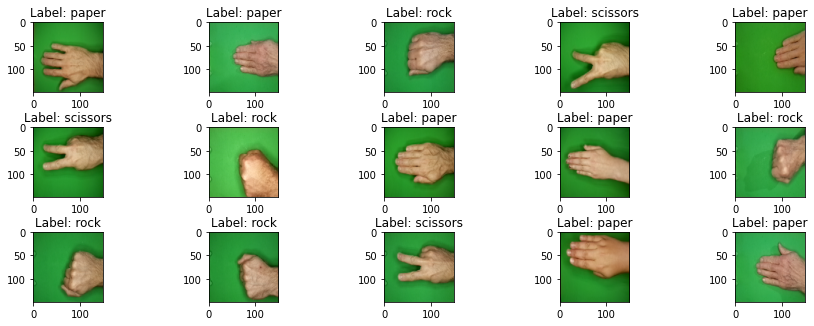

In [6]:
plt.figure(figsize = (15 , 9))
n = 0
for i in range(15):
    n+=1
    plt.subplot(5 , 5, n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
    plt.imshow(images[i])
    plt.title(f'Label: {labels[label[i]]}')

In [7]:
np.unique(label,return_counts=True)

(array([0, 1, 2]), array([712, 750, 726]))

In [8]:
from sklearn.model_selection import train_test_split

xtrain,xtest,ytrain,ytest = train_test_split(images,label,stratify=label,random_state=42,test_size=0.25)

print(f"Train length:{len(xtrain)} \n Test length: {len(xtest)}")

Train length:1641 
 Test length: 547


In [9]:
datagen = ImageDataGenerator(horizontal_flip=True,
                             vertical_flip=True,
                             rotation_range=20,
                             zoom_range=0.2,
                             width_shift_range = 0.2,
                             height_shift_range = 0.2,
                             shear_range=0.1,
                             fill_mode="nearest")


datagen.fit(xtrain)

In [10]:
model = Sequential()
model.add(Conv2D(32, (3,3), input_shape=(150,150,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(32, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(units=512, activation='relu'))
model.add(Dense(units=3, activation='softmax'))

2022-04-25 03:56:29.621593: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-25 03:56:29.710558: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-25 03:56:29.711329: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-25 03:56:29.712451: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [11]:
model.compile(optimizer = tf.keras.optimizers.Adam(lr = 0.001), loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [12]:
print("No fo Layers: ",len(model.layers))

No fo Layers:  7


In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 41472)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               21234176  
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1

In [14]:
filepath= "best_model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', save_weights_only=False)

early_stopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

# learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
#                                             patience=3, 
#                                             verbose=1, 
#                                             factor=0.2, 
#                                             min_lr=0.00001)

callbacks_list = [
        checkpoint,
        early_stopping,
#         learning_rate_reduction
    ]

In [15]:
%%time 
h = model.fit_generator(datagen.flow(xtrain,ytrain,batch_size=32),
                                        validation_data=(xtest,ytest),
                                        epochs=50,
                                        callbacks=callbacks_list)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-04-25 03:56:32.543154: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-04-25 03:56:33.980120: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


52/52 [==============================] - 15s 160ms/step - loss: 1.3528 - accuracy: 0.4071 - val_loss: 0.9656 - val_accuracy: 0.4570

Epoch 00001: val_accuracy improved from -inf to 0.45704, saving model to best_model.h5
Epoch 2/50
52/52 [==============================] - 8s 151ms/step - loss: 0.7566 - accuracy: 0.6825 - val_loss: 0.3256 - val_accuracy: 0.9141

Epoch 00002: val_accuracy improved from 0.45704 to 0.91408, saving model to best_model.h5
Epoch 3/50
52/52 [==============================] - 7s 142ms/step - loss: 0.4938 - accuracy: 0.8178 - val_loss: 0.2136 - val_accuracy: 0.9433

Epoch 00003: val_accuracy improved from 0.91408 to 0.94333, saving model to best_model.h5
Epoch 4/50
52/52 [==============================] - 7s 140ms/step - loss: 0.3209 - accuracy: 0.8982 - val_loss: 0.1335 - val_accuracy: 0.9726

Epoch 00004: val_accuracy improved from 0.94333 to 0.97258, saving model to best_model.h5
Epoch 5/50
52/52 [==============================] - 8s 148ms/step - loss: 0.2562 

In [16]:
best_model =  tf.keras.models.load_model('best_model.h5')


In [17]:
from sklearn.metrics import classification_report

print(classification_report(ytest,np.argmax(best_model.predict(xtest),axis = 1),target_names = labels))

              precision    recall  f1-score   support

       paper       0.97      0.98      0.98       178
    scissors       0.99      0.98      0.98       188
        rock       0.99      0.99      0.99       181

    accuracy                           0.99       547
   macro avg       0.99      0.99      0.99       547
weighted avg       0.99      0.99      0.99       547



In [18]:
pred = best_model.predict(xtest)
pred = np.argmax(pred,axis = 1)

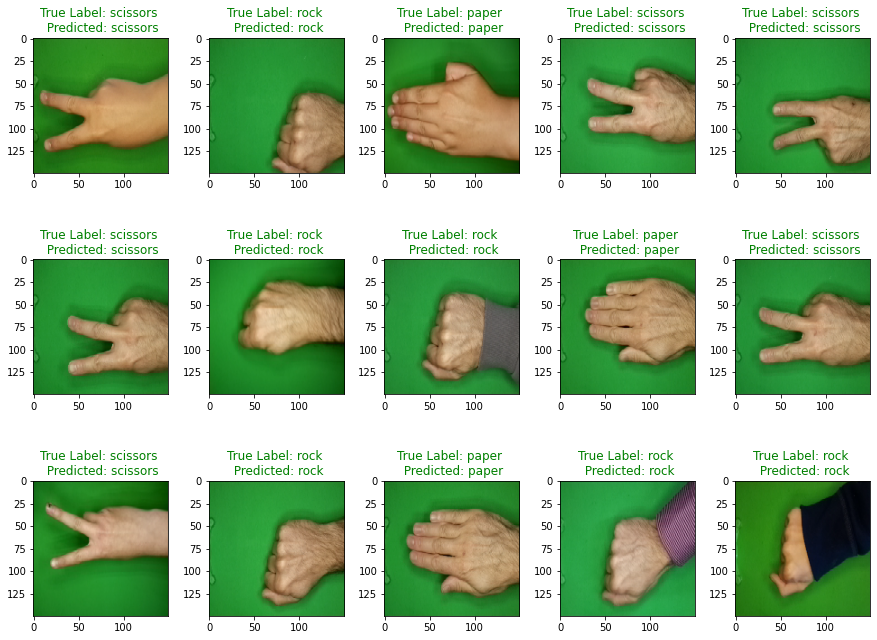

In [19]:
plt.figure(figsize = (15 , 19))
n = 0
for i in range(15):
    if pred[i]==ytest[i]:
        
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
        plt.title(f'True Label: {labels[ytest[i]]} \n Predicted: {labels[pred[i]]}',color = 'green')

        plt.imshow(xtest[i])
#         plt.xlabel(f"",color="green")
    else:
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
        plt.title(f'True Label: {labels[ytest[i]]} \n Predicted: {labels[pred[i]]}',color = 'red')

        plt.imshow(xtest[i])
        

In [20]:
print('Time elapsed (hh:mm:ss.ms) {}'.format(datetime.now() - start_time))

Time elapsed (hh:mm:ss.ms) 0:03:09.378973
